In [ ]:
!pip install --upgrade -q gdown
!pip install html2text -q

!mkdir /content/data/
!gdown 14dYvGXRVD1Prtr7SXHrwO6ZpfGk0F5aT
!unzip /content/internship_2023.zip -d /content/data/

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from glob import glob
from PIL import Image

from ast import literal_eval
from html2text import HTML2Text

In [3]:
train = pd.read_parquet("/content/data/train.parquet")
test = pd.read_parquet("/content/data/test.parquet")
data = pd.concat([train,test])

In [4]:
train.head(5)

,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...
1,888134,14233,False,18305,Sela,5.0,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",Все категории->Одежда->Женская одежда->Белье и...
3,1267173,13429,False,16357,ЮНЛАНДИЯ канцтовары,5.0,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов...",Все категории->Хобби и творчество->Рисование->...
4,1416943,2789,False,34666,вася-nicotine,4.0,"{""title"": ""Колба для кальяна Крафт (разные цве...",Все категории->Хобби и творчество->Товары для ...
5,1058275,12834,False,26389,Lim Market,4.6,"{""title"": ""Пижама женская, однотонная с шортам...",Все категории->Одежда->Женская одежда->Домашня...


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91120 entries, 0 to 99992
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     91120 non-null  int64  
 1   category_id    91120 non-null  int64  
 2   sale           91120 non-null  bool   
 3   shop_id        91120 non-null  int64  
 4   shop_title     91120 non-null  object 
 5   rating         91120 non-null  float64
 6   text_fields    91120 non-null  object 
 7   category_name  91120 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 5.6+ MB


In [6]:
print("Размер train датасета", train.shape)
print("Размер test датасета ", test.shape )

Размер train датасета (91120, 8)
Размер test датасета  (16860, 6)


In [7]:
# Посмотрим на пропущенные значения
print('Train')
print('Столбец ', 'Кол-во пропусков')
print(train.isna().sum())

print(' ')

print('Test')
print('Столбец ', 'Кол-во пропусков')
print(test.isna().sum())

Train
Столбец  Кол-во пропусков
product_id       0
category_id      0
sale             0
shop_id          0
shop_title       0
rating           0
text_fields      0
category_name    0
dtype: int64
 
Test
Столбец  Кол-во пропусков
product_id     0
sale           0
shop_id        0
shop_title     0
rating         0
text_fields    0
dtype: int64


In [8]:
NUM_CLASSES = len(train.category_id.unique())
print('Кол-во уникальных категорий товаров:', NUM_CLASSES)

Кол-во уникальных категорий товаров: 874


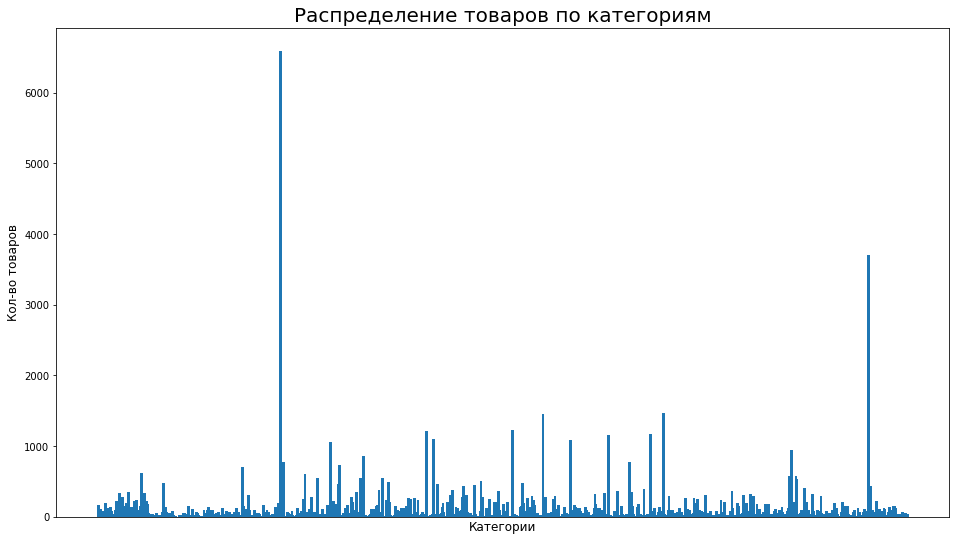

In [9]:
plt.figure(figsize=(16,9))
plt.bar(range(NUM_CLASSES), train.groupby("category_id")["product_id"].count(), width=3)
plt.title("Распределение товаров по категориям", fontsize=20)
plt.xlabel("Категории", fontsize=12)
plt.xticks([])
plt.ylabel("Кол-во товаров", fontsize=12)
plt.show()

In [10]:
print('Среднее кол-во продуктов в категории:', train.groupby("category_id")["product_id"].count().mean())
print('Медианное кол-во продуктов в категории:', train.groupby("category_id")["product_id"].count().median())

# выведем кол-во категорий, которым соответсвует N и менее товаров
N = 1
print(f'Кол-во категорий, которым соответствует {N} и менее продуктов:',
      train.groupby('category_id').count()[train.groupby('category_id').count()['product_id'] <= N].shape[0])

Среднее кол-во продуктов в категории: 104.25629290617849
Медианное кол-во продуктов в категории: 38.0
Кол-во категорий, которым соответствует 1 и менее продуктов: 4


На графике видно, что количество примеров в каждом классе не одинаковое. Есть классы у которых более 6000 примеров, есть те у которых всего один. Это необходимо учесть при препроцессинге данных.

In [11]:
print('Кол-во товаров со скидкой:', train['sale'].value_counts()[0])
print('Кол-во товаров без скидки:', train['sale'].value_counts()[1])

Кол-во товаров со скидкой: 89896
Кол-во товаров без скидки: 1224


In [12]:
NUM_SHOPS_TRAIN = len(train['shop_id'].unique())
NUM_SHOPS_TEST = len(test['shop_id'].unique())
NUM_SHOPS_DATA = len(data['shop_id'].unique())

print('Кол-во магазинов в train:', NUM_SHOPS_TRAIN)
print('Кол-во магазинов в test:', NUM_SHOPS_TEST)
print('Кол-во магазинов в test, которых нет в train:', NUM_SHOPS_DATA - NUM_SHOPS_TRAIN)

Кол-во магазинов в train: 10549
Кол-во магазинов в test: 5235
Кол-во магазинов в test, которых нет в train: 577


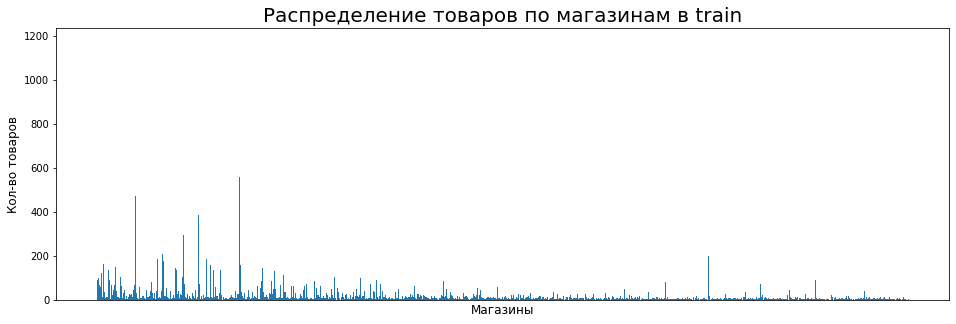

In [13]:
plt.figure(figsize=(16,5))
plt.bar(range(NUM_SHOPS_TRAIN), train.groupby('shop_id')['product_id'].count(), width=3)
plt.title('Распределение товаров по магазинам в train', fontsize=20)
plt.xlabel('Магазины', fontsize=12)
plt.xticks([])
plt.ylabel('Кол-во товаров', fontsize=12)
plt.show()

In [14]:
print("Среднее кол-во товаров в магазине в train:", train.groupby('shop_id')['product_id'].count().mean())
print("Медианное кол-во товаров в магазине в train:", train.groupby('shop_id')['product_id'].count().median())
print(' ')
print("Среднее кол-во категорий в магазине в train:", train.groupby('shop_id')['category_id'].unique().apply(len).mean())
print("Медианное кол-во категорий в магазине в train:", train.groupby('shop_id')['category_id'].unique().apply(len).median())

Среднее кол-во товаров в магазине в train: 8.637785572092142
Медианное кол-во товаров в магазине в train: 3.0
 
Среднее кол-во категорий в магазине в train: 3.673997535311404
Медианное кол-во категорий в магазине в train: 2.0


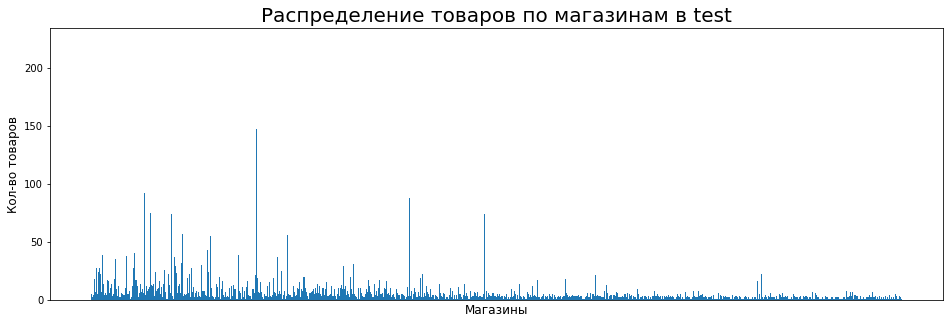

In [15]:
plt.figure(figsize=(16,5))
plt.bar(range(NUM_SHOPS_TEST), test.groupby('shop_id')['product_id'].count(), width=3)
plt.title('Распределение товаров по магазинам в test', fontsize=20)
plt.xlabel('Магазины', fontsize=12)
plt.xticks([])
plt.ylabel('Кол-во товаров', fontsize=12)
plt.show()

In [16]:
print("Среднее кол-во товаров в магазине в test:", test.groupby('shop_id')['product_id'].count().mean())
print("Медианное кол-во товаров в магазине в test:", test.groupby('shop_id')['product_id'].count().median())

Среднее кол-во товаров в магазине в test: 3.2206303724928365
Медианное кол-во товаров в магазине в test: 1.0


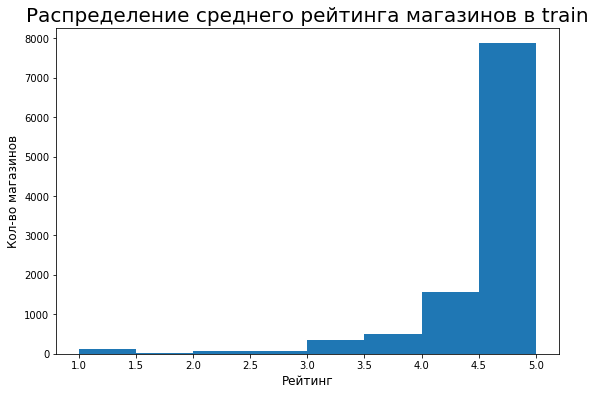

In [17]:
counts, bins = np.histogram(train.groupby('shop_id')['rating'].mean(), bins=8)
plt.figure(figsize=(9,6))
plt.stairs(counts, bins, fill=True)
plt.title('Распределение среднего рейтинга магазинов в train', fontsize=20)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Кол-во магазинов', fontsize=12)
plt.show()

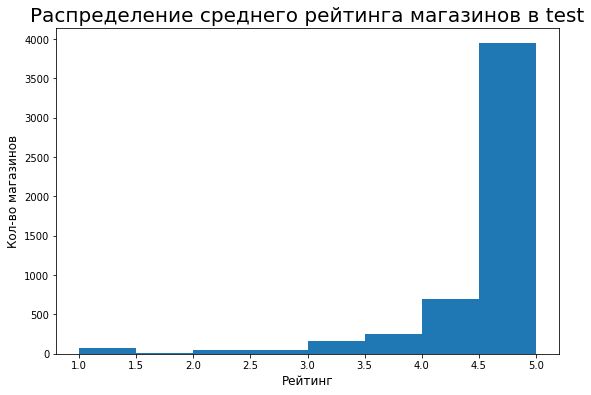

In [18]:
counts, bins = np.histogram(test.groupby('shop_id')['rating'].mean(), bins=8)
plt.figure(figsize=(9,6))
plt.stairs(counts, bins, fill=True)
plt.title('Распределение среднего рейтинга магазинов в test', fontsize=20)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Кол-во магазинов', fontsize=12)
plt.show()

In [19]:
# преобразуем text_fields из str в dict
train['text_fields'] = train['text_fields'].apply(literal_eval)

# распарсим text_fields в отдельные столбцы
for key in train['text_fields'][0].keys():
    train[key] = train['text_fields'].apply(lambda x: x[key])

train.drop('text_fields', axis=1, inplace=True)
train.head()

,product_id,category_id,sale,shop_id,shop_title,rating,category_name,title,description,attributes,custom_characteristics,defined_characteristics,filters
0,325286,12171,False,9031,Aksik,5.0,Все категории->Электроника->Смартфоны и телефо...,Зарядный кабель Borofone BX1 Lightning для айф...,"<p><span style=""background-color: transparent;...","[Длина: 1м, Разъем: Lightning, Подерживает быс...",{},"{'Цвет': ['Черный', 'Белый']}","{'Цвет': ['Белый', 'Черный']}"
1,888134,14233,False,18305,Sela,5.0,Все категории->Одежда->Женская одежда->Белье и...,Трусы Sela,Трусы-слипы из эластичного бесшовного трикотаж...,[],{},{'Размер одежды': ['S']},"{'Бренд': ['Sela'], 'Размер одежды': ['S']}"
3,1267173,13429,False,16357,ЮНЛАНДИЯ канцтовары,5.0,Все категории->Хобби и творчество->Рисование->...,"Гуашь ""ЮНЫЙ ВОЛШЕБНИК"", 12 цветов по 35 мл, БО...",<p>Гуашь высшего качества ЮНЛАНДИЯ поможет соз...,[],{},{},{'Бренд': ['Юнландия']}
4,1416943,2789,False,34666,вася-nicotine,4.0,Все категории->Хобби и творчество->Товары для ...,Колба для кальяна Крафт (разные цвета),"<p><span style=""color: rgb(149, 151, 153);"">Ун...","[Материал: стекло, Внутренний диаметр: 45 мм ,...",{},"{'Цвет': ['Хром', 'Розовый', 'Желтый', 'Прозра...","{'Цвет': ['Прозрачный', 'Желтый', 'Синий', 'Ро..."
5,1058275,12834,False,26389,Lim Market,4.6,Все категории->Одежда->Женская одежда->Домашня...,"Пижама женская, однотонная с шортами",<p>Лёгкая ткань! Комфортная посадка! Идеальная...,[],{},"{'Размер одежды': ['XXXL', 'L', 'XXL', 'XL'], ...","{'Цвет': ['Белый', 'Белый', 'Белый', 'Белый'],..."


In [20]:
# преобразуем description из html кода в текст
parser = HTML2Text()
parser.escape_snob = True
parser.ignore_anchors = True
parser.skip_internal_links = True
parser.ignore_links = True
parser.ignore_images = True

train['description'] = train['description'].apply(parser.handle)
train['description'] = train['description'].apply(lambda x: x.replace('\n', ' '))
train['description'] = train['description'].apply(lambda x: x.replace('\\', ''))
train['description'] = train['description'].apply(lambda x: x.replace('*', ''))

In [21]:
train['description']

0        Зарядный кабель Borofone BX1 подходит для заря...
1        Трусы-слипы из эластичного бесшовного трикотаж...
3          Гуашь высшего качества ЮНЛАНДИЯ поможет созд...
4          Универсальная колба для кальяна Craft подход...
5          Лёгкая ткань! Комфортная посадка! Идеальная ...
                               ...                        
99987      ## Защитное стекло 2D для Samsung Galaxy J5 ...
99988      Алмазная мозаика - очень увлекательное совре...
99989                Открытка 1015 в крафтовом конверте.  
99990      Подходит к аппаратуре Ролсен:  Rolsen телеви...
99992      пульт для спутникового ресивера МТС AVIT S2-...
Name: description, Length: 91120, dtype: object

Посмотрим на кол-во слов в текстовых данных. Эта информация может быть полезна в дальнейшем.

In [24]:
print('Train')
print('Среднее кол-во слов в description: ', train['description'].apply(lambda x: len(x.split())).mean())
print('Медианное кол-во слов в description: ', train['description'].apply(lambda x: len(x.split())).median())
print('Стандартное отклонение кол-ва слов в description: ', train['description'].apply(lambda x: len(x.split())).std())
print(' ')
print('Среднее кол-во слов в title: ', train['title'].apply(lambda x: len(x.split())).mean())
print('Медианное кол-во слов в title: ', train['title'].apply(lambda x: len(x.split())).median())
print('Стандартное отклонение кол-ва слов в title: ', train['title'].apply(lambda x: len(x.split())).std())

Train
Среднее кол-во слов в description:  74.382594381036
Медианное кол-во слов в description:  53.0
Стандартное отклонение кол-ва слов в description:  85.21142023782225
 
Среднее кол-во слов в title:  7.201174275680422
Медианное кол-во слов в title:  7.0
Стандартное отклонение кол-ва слов в title:  3.635104802075788


Заметим, что стандартное отклонение кол-ва слов в description больше чем среднее это означает, что в датасете есть очень большие описания, которые оказывают влияния на полученные числа.

In [25]:
# посмотрим на изображения
IMG_TRAIN_PATH = '/content/data/images/train'
IMG_TEST_PATH = '/content/data/images/test'

IMG_TRAIN = glob(IMG_TRAIN_PATH + '/*')
IMG_TEST = glob(IMG_TEST_PATH + '/*')

assert len(IMG_TRAIN) == train.shape[0], 'Кол-во фотографий не соотвествует кол-ву продуктов в train'
print('Кол-во фотографий соотвествует кол-ву продуктов в train')

assert len(IMG_TEST) == test.shape[0], 'Кол-во фотографий не соотвествует кол-ву продуктов в test'
print('Кол-во фотографий соотвествует кол-ву продуктов в test')

Кол-во фотографий соотвествует кол-ву продуктов в train
Кол-во фотографий соотвествует кол-ву продуктов в test


In [26]:
def show_images(img_path):
    # img_path - массив из абсолютных путей к изображениям
    # выводит до 25 изображений

    fig = plt.figure(figsize=(16, 16))

    rows = 5
    columns = 5

    readed_img = []
    for i, img in enumerate(img_path, start=1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(Image.open(img))
        plt.axis('off')

Изображения train датасета

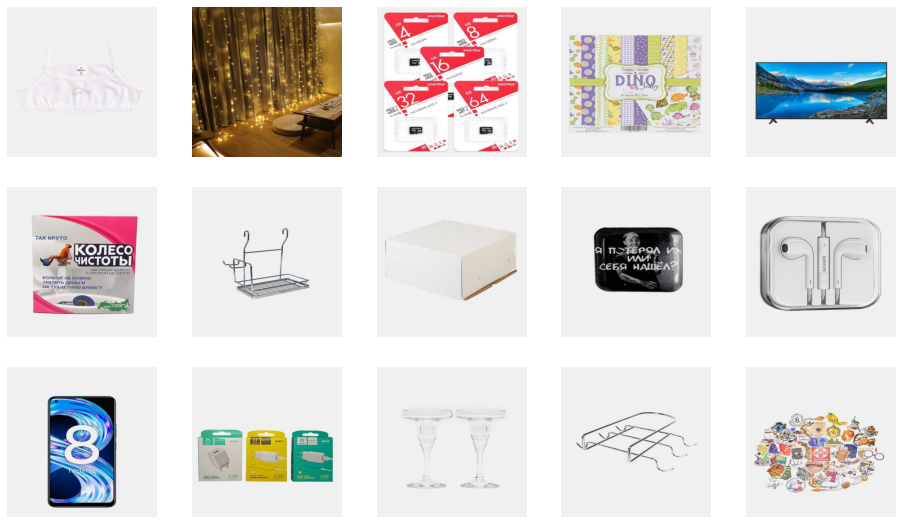

In [27]:
show_images(IMG_TRAIN[:15])

Изображения test датасета

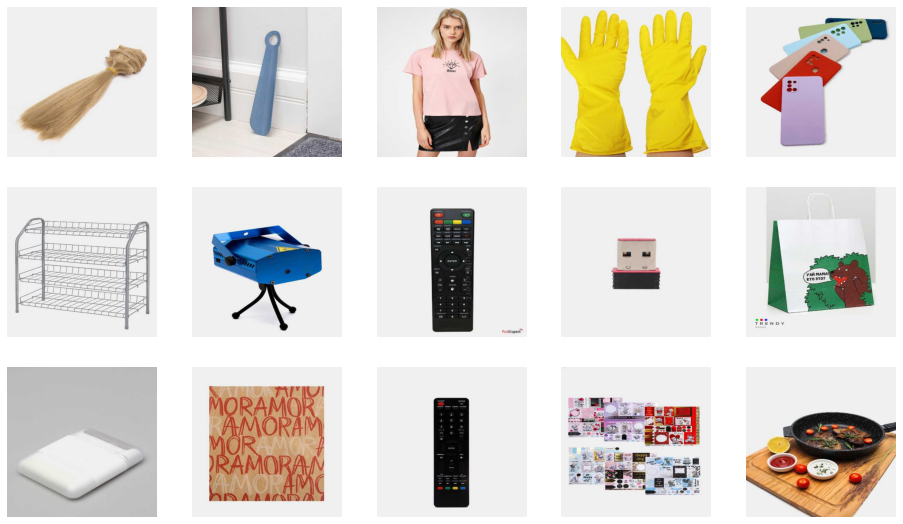

In [28]:
show_images(IMG_TEST[:15])

In [29]:
# посмотрим на размерность фотографий
def get_img_sizes(img_path):
    # img_path массив из путей к фотографиям
    img_sizes = []
    for img in img_path:
        size = Image.open(img).size
        img_sizes.append(size)
    return img_sizes


img_sizes_train = get_img_sizes(IMG_TRAIN)
img_sizes_test = get_img_sizes(IMG_TEST)

if len(set(img_sizes_train)) == 1:
    print('Все изображения в train одного размера: ', img_sizes_train[0])
else:
    print('Изображения в train имеют разную размерность')

if len(set(img_sizes_test)) == 1:
    print('Все фотографии в test одного размера: ', img_sizes_train[0])
else:
    print('Изображения в test имеют разную размерность')

Все изображения в train одного размера:  (512, 512)
Все фотографии в test одного размера:  (512, 512)
